In [1]:
import numpy as np
from scipy.optimize import fsolve
from IPython.display import display, Markdown
from sympy import *
from sympy import latex as ltx

# Derivatives
x = symbols(r'x', real=True)
N1, N2 = symbols(r'N_1 N_2', real=True)
d1, d2, d3 = symbols(r'd_1 d_2 d_3', real=True)
N1 = x * d1 / ( 10 - d1) - 0.5 * d2**2
N2 = d2 - d1

display ( Markdown( f"$\\frac{{\\partial N_1}}{{\\partial d_1}} = {ltx(diff(N1,d1))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_1}}{{\\partial d_2}} = {ltx(diff(N1,d2))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_2}}{{\\partial d_1}} = {ltx(diff(N2,d1))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_2}}{{\\partial d_2}} = {ltx(diff(N2,d2))}$" ) )


$\frac{\partial N_1}{\partial d_1} = \frac{d_{1} x}{\left(10 - d_{1}\right)^{2}} + \frac{x}{10 - d_{1}}$

$\frac{\partial N_1}{\partial d_2} = - 1.0 d_{2}$

$\frac{\partial N_2}{\partial d_1} = -1$

$\frac{\partial N_2}{\partial d_2} = 1$

In [2]:
import numpy as np
from scipy.optimize import fsolve


# HELPER
def cN1(x,d_) :
    if not len(d_) : return []
    return x * d_[0] / (10. - d_[0]) - 0.5 * d_[1]**2
def cN2(x,d_) :
    if not len(d_) : return []
    return d_[1] - d_[0]
def cN(x,d_) :
    if not len(d_) : return []
    return [ cN1(x,d_), cN2(x,d_) ]
def cG( dd_, R_) : return dd_ @ R_

#
# MAIN ENGINE
#
def run_sim( x, line_search=False, modif_nr=False,  line_search_maxit=1000, line_search_fast_s=False, BFGS=False ) :
    global G0,d, delta_d, K_inv, v_, alpha_, w_, delta_R_, R_, R
    # Load steps
    dF_ = np.array( [ 0.25, 0 ] )
    F_ = np.zeros(2)
    
    s=1 # line search
    RET_F, RET_D, RET_I = [], [], []
    
    # Load steps
    d_ = np.array( [ 0. , 0. ] )
    N_ = cN(x,d_)
    
    for n in range(40) :
        F_ += dF_

        print(f"Running LOAD STEP {n} (F={F_})")
        CONVERGED = False

        # INITIALIZE THE RESIDUAL
        N_ = cN(x,d_)
        R_ = F_ - N_
        r0 = np.linalg.norm(R_)
        r = r0
        # NEWTON ITERATIONS
        for i in range(15) :
            print(f"   Netwon step {i} (r:{r:.4f})")
            # UPDATE THE TANGENT MATRIX
            if not modif_nr or not i :
                K = np.array( [ [ d_[0] * x / (10 - d_[0])**2 + x / (10 - d_[0]),           -d_[1] ] ,
                                [-1,                                                            1] ] )
            
            # UPDATE BFGS PREDICTOR AFTER FIRST TIMESTEP
            if i and BFGS :
                Rbfgs_ = R_ + ( v_ @ R_ ) * w_
                dd0_ = np.linalg.inv( K ) @ Rbfgs_
                dd_ = dd0_ + ( w_ @ v_ ) * dd0_
            else :
                # UPDATE THE SEARCH DIRECTION
                dd_ = np.linalg.inv(K) @ R_ 

            # UPDATE LINE SEARCH G0 (before d_ update)
            g0 = cG( dd_, R_ )

            # SAVE & UPDATE d_
            prev_d_ = d_.copy()
            d_ += dd_
            # TRIAL RESIDUAL
            tR_ = F_ - cN(x,d_)

            # UPDATE LINE SEARCH G1 (after d_ update)
            g1 = cG( d_, tR_)
            
            # UPDATE LINE SEARCH
            if line_search :
                print("        Line search enabled.")

                def foo(_s):
                    gs = cG( dd_ ,      F_ - cN(x, prev_d_ + _s*dd_) )
                    [N1,N2] = cN(x, prev_d_ + _s*dd_)
                    if line_search_fast_s :
                        if abs(gs) < abs(g0/2) : print("        FAST S!") ; return 0 
                    return gs

                print(f"        Find s ... ")
                s = fsolve(foo,0, maxfev=line_search_maxit)[0]
                       
                test_f = abs(foo(s))
                if abs(test_f)>abs(g0/2)+1e-4 :
                    print(f"[FAILED] Cannot find acceptable s in line search - test_f[{test_f:.4e} > abs(g0/2)[{abs(g0/2):.4e}]]")
                    return RET_D, RET_F, RET_I

            # UPDATE THE DOFs BASED ON THE LINE SEARCH
            d_ = prev_d_ + dd_ * s
            
            # SAVE & UPDATE R_
            prev_R_ = R_.copy()
            R_ = F_ - cN(x,d_)

            # UPDATE GS
            gs = cG( dd_, R_)
            
            r = np.linalg.norm(R_)
            if r > 1e50 : break  # Crash!
            if r/r0 < 1e-4 : CONVERGED = True ; break

            # UPDATE BFGS VECTORS
            if BFGS :
                v_ = dd_ / (gs - g0)
                alpha = np.sqrt( np.max( [ 0, - s * (gs - g0)/ g0 ] ) )
                w_ = (alpha - 1) * R_ - prev_R_

                print("Update BFGS vectors:")
                print(f"s:{s} gs_:{gs} g0:{g0}")
                print(f"alpha:{alpha} R_:{R_} prev_R_:{prev_R_}")

        if not CONVERGED : 
            print(f"[FAILED] The solver did not converge after {i} iterations. Giving up.")    
            return RET_D, RET_F, RET_I
                        
        RET_D.append(d_.copy())
        RET_I.append(i+1)
        RET_F.append(F_[0])

    print(RET_I)
    return RET_D, RET_F, RET_I
    
    
#full_run( line_search=0, modif_nr=1, line_search_maxit=10000, line_search_fast_s=False, BFGS=1 )


#### 1) Exact $N_1(d_1,d_2=d_1)$ vs. $d_1$ for x=15 and x=25

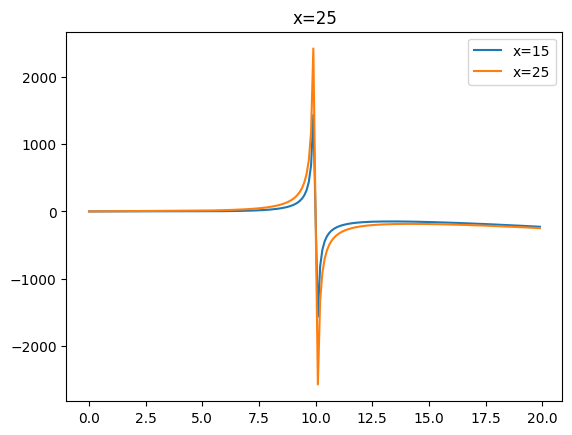

In [3]:
import matplotlib.pyplot as plt
import numpy as np

d0_ = np.arange(0,20,.1)
d0 = np.array( [ i for i in d0_ if i != 10] )

d0 = [ d0, d0 ]
N15exact = cN1(15,d0)
plt.plot( d0[0], N15exact, label="x=15" )
plt.title("x=15")
N25exact = cN1(25,d0)
plt.plot( d0[0], N25exact, label="x=25" )
plt.title("x=25")
plt.legend()

In [10]:
import matplotlib.pyplot as plt
def full_run(line_search, modif_nr=False,  line_search_maxit=1000, line_search_fast_s=False, BFGS=False) :
    x=15
    D15,F15,I15 = run_sim( x=x, line_search=line_search, modif_nr=modif_nr, line_search_maxit=line_search_maxit, line_search_fast_s=line_search_fast_s, BFGS=BFGS )
    d15 = np.array( [ [i,i] for i,j in D15 ] ).T
    N15 = cN1(x,d15)
    
    x=25
    D25,F25,I25 = run_sim( x=x, line_search=line_search, modif_nr=modif_nr, line_search_maxit=line_search_maxit, line_search_fast_s=line_search_fast_s, BFGS=BFGS )
    d25 = np.array( [ [i,i] for i,j in D25 ] ).T
    N25 = cN1(x,d25)
    
    # PLOT NUMERICAL
    if len(d15) : plt.scatter( d15[0], N15, label="NUM x=15", marker='x' )
    if len(d25) : plt.scatter( d25[0], N25, label="NUM x=25", marker='x' )
    # PLOT EXACT
    d0_ = np.arange(0,7,.1)
    d0 = np.array( [ i for i in d0_ if i != 10] )
    d0 = [ d0, d0 ]
    N15exact = cN1(15,d0)
    plt.plot( d0[0], N15exact, label="EXACT x=15" )
    N25exact = cN1(25,d0)
    plt.plot( d0[0], N25exact, label="EXACT x=25" )
    plt.legend()
    
    plt.figure()
    plt.plot(F15,I15,label="Iterations x=15")
    plt.plot(F25,I25,label="Iterations x=25")

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0097)
Running LOAD STEP 1 (F=[0.5 0. ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0111)
   Netwon step 2 (r:0.0000)
Running LOAD STEP 2 (F=[0.75 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0131)
   Netwon step 2 (r:0.0000)
Running LOAD STEP 3 (F=[1. 0.])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0160)
   Netwon step 2 (r:0.0001)
Running LOAD STEP 4 (F=[1.25 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0203)
   Netwon step 2 (r:0.0002)
Running LOAD STEP 5 (F=[1.5 0. ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0278)
   Netwon step 2 (r:0.0005)
Running LOAD STEP 6 (F=[1.75 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0434)
   Netwon step 2 (r:0.0026)
Running LOAD STEP 7 (F=[2. 0.])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0940)
   Netwon step 2 (r:0.0430)
   Netwon step 3 (r:0.0697)
   Netwon step 4 (r:0.0137)
   Netwon step 5 (r:0.00

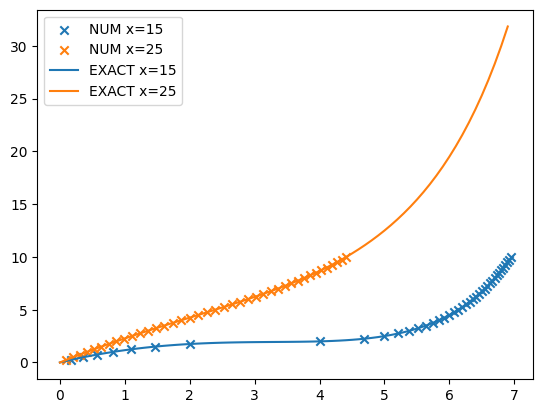

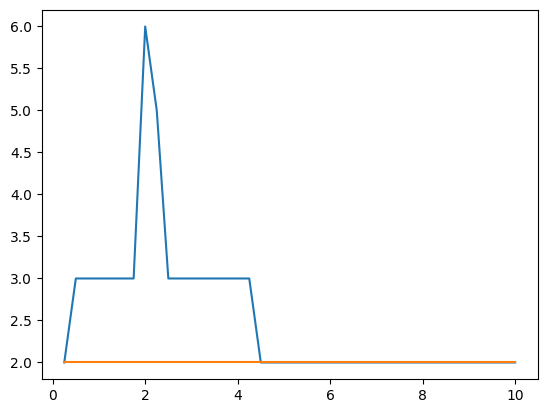

In [5]:
full_run( line_search=0, modif_nr=False, line_search_maxit=10000, line_search_fast_s=False )

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 1 (F=[0.5 0. ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 2 (F=[0.75 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 3 (F=[1. 0.])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 4 (F=[1.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 5 (F=[1.5 0. ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 6 (F=[1.75 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 7 (F=[2. 0.])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 8 (F=[2.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s 

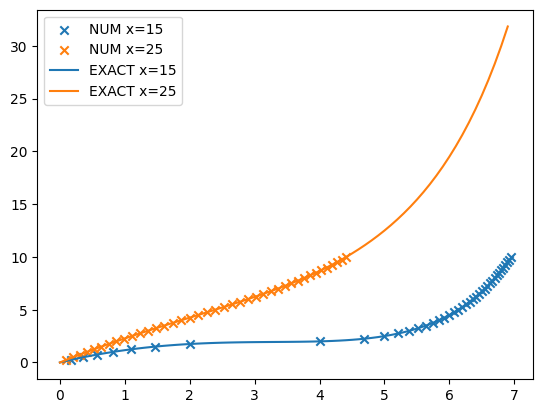

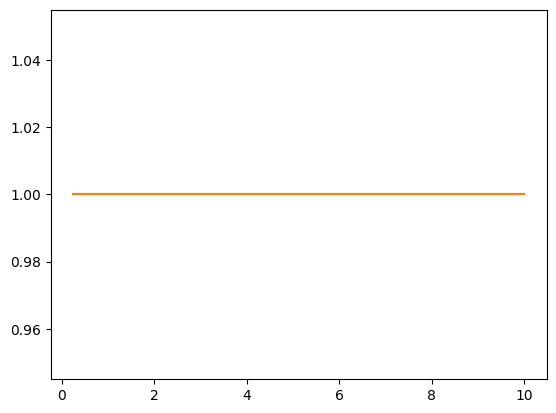

In [6]:
full_run( line_search=True, modif_nr=False, line_search_maxit=10000, line_search_fast_s=False )

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0097)
   Netwon step 2 (r:0.0008)
   Netwon step 3 (r:0.0001)
Running LOAD STEP 1 (F=[0.5 0. ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0111)
   Netwon step 2 (r:0.0010)
   Netwon step 3 (r:0.0001)
Running LOAD STEP 2 (F=[0.75 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0131)
   Netwon step 2 (r:0.0014)
   Netwon step 3 (r:0.0002)
Running LOAD STEP 3 (F=[1. 0.])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0160)
   Netwon step 2 (r:0.0021)
   Netwon step 3 (r:0.0003)
   Netwon step 4 (r:0.0000)
Running LOAD STEP 4 (F=[1.25 0.  ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0203)
   Netwon step 2 (r:0.0034)
   Netwon step 3 (r:0.0006)
   Netwon step 4 (r:0.0001)
Running LOAD STEP 5 (F=[1.5 0. ])
   Netwon step 0 (r:0.2500)
   Netwon step 1 (r:0.0278)
   Netwon step 2 (r:0.0064)
   Netwon step 3 (r:0.0016)
   Netwon step 4 (r:0.0004)
   Netwon step 5 (r:0.0001)
Running 

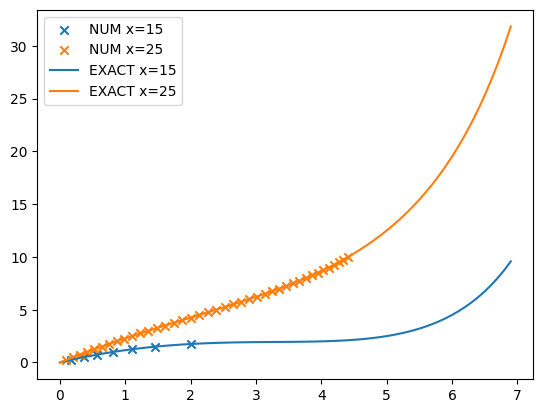

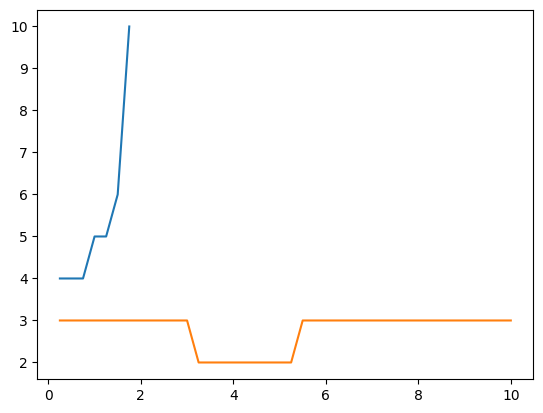

In [7]:
full_run( line_search=False, modif_nr=True, line_search_maxit=10000, line_search_fast_s=False )

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
   Netwon step 1 (r:0.0097)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
Running LOAD STEP 1 (F=[0.5 0. ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
   Netwon step 1 (r:0.0111)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
   Netwon step 2 (r:0.0000)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
Running LOAD STEP 2 (F=[0.75 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
   Netwon step 1 (r:0.0131)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
   Netwon step 2 (r:0.0000)
        Line search enabled.
        Find s ... 
        FAST S!
        FAST S!
Running LOAD STEP 3 (F

C:\Users\BFQ9\AppData\Local\Temp\ipykernel_15368\3834573189.py:85: RuntimeWarning: The number of calls to function has reached maxfev = 5.
  s = fsolve(foo,0, maxfev=line_search_maxit)[0]


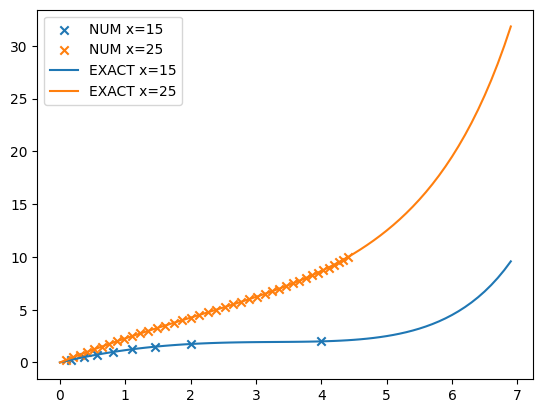

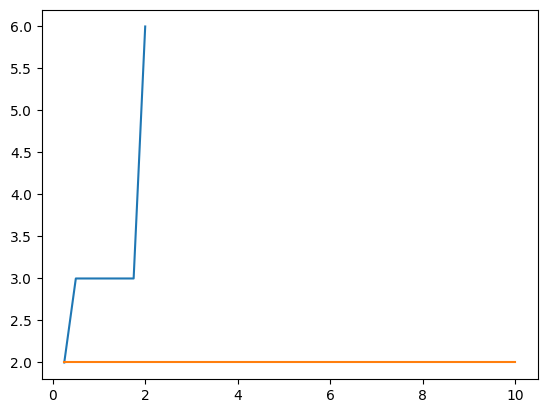

In [8]:
full_run( line_search=True, modif_nr=True, line_search_maxit=5, line_search_fast_s=True )

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
Update BFGS vectors:
s:1 gs_:0.001608600125549281 g0:0.041666666666666664
alpha:0.9805068061909704 R_:[0.0096516 0.       ] prev_R_:[0.25 0.  ]
   Netwon step 1 (r:0.0097)
Update BFGS vectors:
s:1 gs_:-0.0007293733031285464 g0:0.000258682885525607
alpha:1.9543708346983404 R_:[-0.02721332  0.        ] prev_R_:[0.0096516 0.       ]
   Netwon step 2 (r:0.0272)
Update BFGS vectors:
s:1 gs_:-0.004931839207054423 g0:0.0019088809307227185
alpha:1.8930474152577803 R_:[0.07030911 0.        ] prev_R_:[-0.02721332  0.        ]
   Netwon step 3 (r:0.0703)
Update BFGS vectors:
s:1 gs_:-0.0285203803173735 g0:0.012185455848017784
alpha:1.8277106814512352 R_:[-0.16456032  0.        ] prev_R_:[0.07030911 0.        ]
   Netwon step 4 (r:0.1646)
Update BFGS vectors:
s:1 gs_:-0.1507674409078371 g0:0.06375948709630935
alpha:1.8342921163147208 R_:[0.38912386 0.        ] prev_R_:[-0.16456032  0.        ]
   Netwon step 5 (r:0.3891)
Update BFGS v

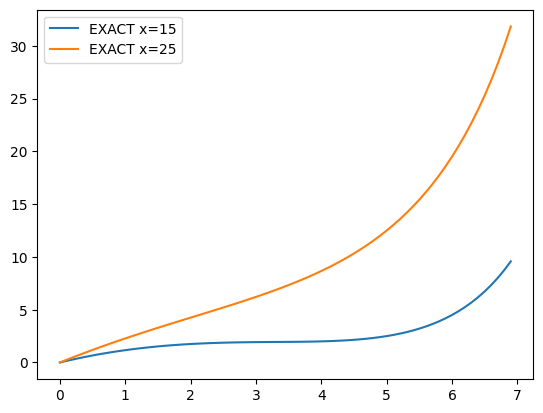

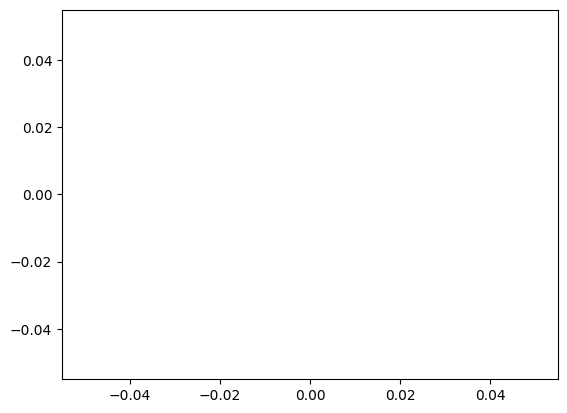

In [11]:
full_run( line_search=False, modif_nr=True, line_search_maxit=10000, line_search_fast_s=False, BFGS=True )

Running LOAD STEP 0 (F=[0.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 1 (F=[0.5 0. ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 2 (F=[0.75 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 3 (F=[1. 0.])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 4 (F=[1.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 5 (F=[1.5 0. ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 6 (F=[1.75 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 7 (F=[2. 0.])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s ... 
Running LOAD STEP 8 (F=[2.25 0.  ])
   Netwon step 0 (r:0.2500)
        Line search enabled.
        Find s 

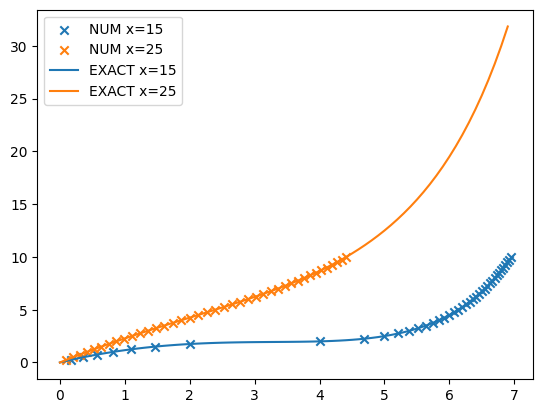

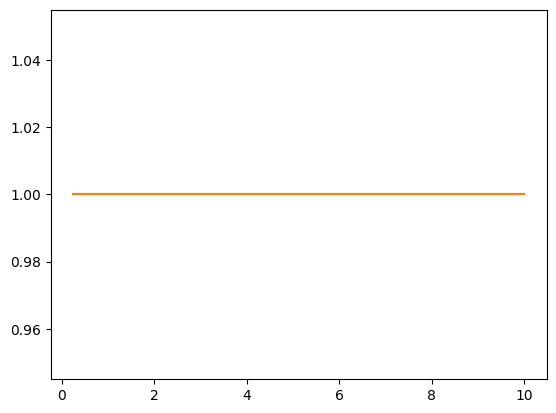

In [12]:
full_run( line_search=True, modif_nr=True, line_search_maxit=10000, line_search_fast_s=False, BFGS=True )

### Comments

1. The consistent tangent strategy works always, but takes more time in line search is disabled.

1. This was true in the case where the tangent changes significantly

1. The modified Newton fails when the tangent changes significantly.

1. The line search is effective in reducing the number of Newton cycles, even with modified newton.

1. Even limiting the resolution of the search parameter (max 5 iterations in the s solver), it helps the solver

